# Data Processing and Predictive Modeling for Zillow's Home Value Prediction

The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016

The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016, while the test data in the private leaderboard uses data between October 17 and December 15, 2017.

You are asked to predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

Not all the properties are sold in each time period. If a property was not sold in a certain time period, that particular row will be ignored when calculating your score.

In [1]:
%load_ext autoreload
%autoreload 2
import src.data_proc as data_proc

import numpy as np
import pandas as pd
import sys
import os
import gc
import random
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
pd.options.display.float_format

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Data loading and Preprocessing

In [ ]:
%%time
# Load in properties data
prop_2016 = data_proc.load_properties_data("data/properties_2016.csv")
prop_2017 = data_proc.load_properties_data("data/properties_2017.csv")

assert len(prop_2016) == len(prop_2017)
print("Number of properties: {}".format(len(prop_2016)))
print("Number of property features: {}".format(len(prop_2016.columns)-1))

In [ ]:
%%time
# Rename & retype the feature columns; also unify representations of missing values
def get_landuse_code_df(prop_2016, prop_2017):
    temp = prop_2016.groupby('county_landuse_code')['county_landuse_code'].count()
    landuse_codes = list(temp[temp >= 300].index)
    temp = prop_2017.groupby('county_landuse_code')['county_landuse_code'].count()
    landuse_codes += list(temp[temp >= 300].index)
    landuse_codes = list(set(landuse_codes))
    df_landuse_codes = pd.DataFrame({'county_landuse_code': landuse_codes,
                                     'county_landuse_code_id': range(len(landuse_codes))})
    return df_landuse_codes

def get_zoning_desc_code_df(prop_2016, prop_2017):
    temp = prop_2016.groupby('zoning_description')['zoning_description'].count()
    zoning_codes = list(temp[temp >= 5000].index)
    temp = prop_2017.groupby('zoning_description')['zoning_description'].count()
    zoning_codes += list(temp[temp >= 5000].index)
    zoning_codes = list(set(zoning_codes))
    df_zoning_codes = pd.DataFrame({'zoning_description': zoning_codes,
                                     'zoning_description_id': range(len(zoning_codes))})
    return df_zoning_codes

def process_columns(df, df_landuse_codes, df_zoning_codes):
    df = df.merge(how='left', right=df_landuse_codes, on='county_landuse_code')
    df = df.drop(['county_landuse_code'], axis=1)
    
    df = df.merge(how='left', right=df_zoning_codes, on='zoning_description')
    df = df.drop(['zoning_description'], axis=1)
    
    df.loc[df.county_id == 3101, 'county_id'] = 0
    df.loc[df.county_id == 1286, 'county_id'] = 1
    df.loc[df.county_id == 2061, 'county_id'] = 2
    
    df.loc[df.landuse_type_id == 279, 'landuse_type_id'] = 261
    return df

data_proc.rename_columns(prop_2016)
data_proc.rename_columns(prop_2017)

df_landuse_codes = get_landuse_code_df(prop_2016, prop_2017)
df_zoning_codes = get_zoning_desc_code_df(prop_2016, prop_2017)
prop_2016 = process_columns(prop_2016, df_landuse_codes, df_zoning_codes)
prop_2017 = process_columns(prop_2017, df_landuse_codes, df_zoning_codes)

data_proc.retype_columns(prop_2016)
data_proc.retype_columns(prop_2017)

prop_2017.head()

In [ ]:
%%time
# Write current DataFrames to hdf5
prop_2016.to_hdf('prop.h5', key='prop_2016', format='table', mode='w')
prop_2017.to_hdf('prop.h5', key='prop_2017', format='table', mode='a')

In [2]:
%%time
# Read DataFrames from hdf5
prop_2016 = pd.read_hdf('prop.h5', 'prop_2016')
prop_2017 = pd.read_hdf('prop.h5', 'prop_2017')

CPU times: user 8.55 s, sys: 1.86 s, total: 10.4 s
Wall time: 11.7 s


In [3]:
# Load in training data (with logerror labels)
train_2016 = data_proc.load_training_data("data/train_2016_v2.csv")
train_2017 = data_proc.load_training_data("data/train_2017.csv")

print("Number of 2016 transaction records: {}".format(len(train_2016)))
print("Number of 2016 transaction records: {}".format(len(train_2017)))
print("\n", train_2016.head())
print("\n", train_2017.head())

Number of 2016 transaction records: 90275
Number of 2016 transaction records: 77613

    parcelid  logerror transactiondate
0  11016594    0.0276      2016-01-01
1  14366692   -0.1684      2016-01-01
2  12098116   -0.0040      2016-01-01
3  12643413    0.0218      2016-01-02
4  14432541   -0.0050      2016-01-02

    parcelid  logerror transactiondate
0  14297519  0.025595      2017-01-01
1  17052889  0.055619      2017-01-01
2  14186244  0.005383      2017-01-01
3  12177905 -0.103410      2017-01-01
4  10887214  0.006940      2017-01-01


# Feature Engineering

In [4]:
# Basic feature engineering + Drop duplicate columns
for prop in [prop_2016, prop_2017]:
    prop['avg_garage_size'] = prop['garage_sqft'] / prop['garage_cnt']
    
    prop['property_tax_per_sqft'] = prop['tax_property'] / prop['finished_area_sqft_calc']
    
    # Rotated Coordinates
    prop['location_1'] = prop['latitude'] + prop['longitude']
    prop['location_2'] = prop['latitude'] - prop['longitude']
    prop['location_3'] = prop['latitude'] + 0.5 * prop['longitude']
    prop['location_4'] = prop['latitude'] - 0.5 * prop['longitude']
    
    # 'finished_area_sqft' and 'total_area' cover only a strict subset of 'finished_area_sqft_calc' in terms of 
    # non-missing values. Also, when both fields are not null, the values are always the same.
    # So we can probably drop 'finished_area_sqft' and 'total_area' since they are redundant
    # If there're some patterns in when the values are missing, we can add two isMissing binary features
    prop['missing_finished_area'] = prop['finished_area_sqft'].isnull().astype(np.float32)
    prop['missing_total_area'] = prop['total_area'].isnull().astype(np.float32)
    prop.drop(['finished_area_sqft', 'total_area'], axis=1, inplace=True)
    
    # Same as above, 'bathroom_cnt' covers everything that 'bathroom_cnt_calc' has
    # So we can safely drop 'bathroom_cnt_calc' and optionally add an isMissing feature
    prop['missing_bathroom_cnt_calc'] = prop['bathroom_cnt_calc'].isnull().astype(np.float32)
    prop.drop(['bathroom_cnt_calc'], axis=1, inplace=True)
    
    # 'room_cnt' has many zero or missing values
    # On the other hand, 'bathroom_cnt' and 'bedroom_cnt' have few zero or missing values
    # Add an derived room_cnt feature by adding bathroom_cnt and bedroom_cnt
    prop['derived_room_cnt'] = prop['bedroom_cnt'] + prop['bathroom_cnt']
    
    # Average area in sqft per room
    mask = (prop.room_cnt >= 1)  # avoid dividing by zero
    prop.loc[mask, 'avg_area_per_room'] = prop.loc[mask, 'finished_area_sqft_calc'] / prop.loc[mask, 'room_cnt']
    
    # Use the derived room_cnt to calculate the avg area again
    mask = (prop.derived_room_cnt >= 1)
    prop.loc[mask,'derived_avg_area_per_room'] = prop.loc[mask,'finished_area_sqft_calc'] / prop.loc[mask,'derived_room_cnt']
    
prop_2017.head()

,parcelid,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,deck_id,floor1_sqft,finished_area_sqft_calc,perimeter_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,county_landuse_code_id,zoning_description_id,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room
0,10754147,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34144440.0,-118654080.0,85768.0,NaN,NaN,NaN,NaN,NaN,238,60378004.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN,15,-1,NaN,NaN,-84509640.0,152798528.0,-25182600.0,93471480.0,1.0,1.0,1.0,0.0,NaN,NaN
1,10759547,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34140432.0,-118625360.0,4083.0,NaN,NaN,NaN,NaN,NaN,230,60378000.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,27,17,NaN,NaN,-84484928.0,152765792.0,-25172248.0,93453112.0,1.0,1.0,1.0,0.0,NaN,NaN
2,10843547,-1,-1,NaN,0.0,0.0,4,NaN,NaN,NaN,73026.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,33989360.0,-118394632.0,63085.0,NaN,NaN,NaN,NaN,NaN,16,60377032.0,51617.0,0,NaN,96095.0,0.0,NaN,NaN,-1,2.0,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.369141,NaN,NaN,NaN,6,4,NaN,0.284835,-84405272.0,152384000.0,-25207956.0,93186676.0,1.0,0.0,1.0,0.0,NaN,NaN
3,10859147,-1,-1,NaN,0.0,0.0,2,6.0,NaN,NaN,5068.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34148864.0,-118437208.0,7521.0,NaN,NaN,NaN,NaN,NaN,16,60371412.0,12447.0,0,27080.0,96424.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1948.0,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.570312,NaN,NaN,NaN,6,4,NaN,2.872449,-84288344.0,152586080.0,-25069740.0,93367468.0,1.0,0.0,1.0,0.0,NaN,NaN
4,10879947,-1,-1,NaN,0.0,0.0,3,NaN,NaN,NaN,1776.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,0,60371232.0,12447.0,0,46795.0,96450.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1947.0,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.169922,NaN,NaN,NaN,37,-1,NaN,3.223632,-84191648.0,152579984.0,-24998740.0,93387076.0,1.0,0.0,1.0,0.0,NaN,NaN


In [5]:
# Compute region-based aggregate features
def add_aggregate_features(df, group_col, agg_cols):
    df[group_col + '-groupcnt'] = df[group_col].map(df[group_col].value_counts())
    new_columns = []  # New feature columns added to the DataFrame

    for col in agg_cols:
        aggregates = df.groupby(group_col, as_index=False)[col].agg([np.mean])
        aggregates.columns = [group_col + '-' + col + '-' + s for s in ['mean']]
        new_columns += list(aggregates.columns)
        df = df.merge(how='left', right=aggregates, on=group_col)
        
    for col in agg_cols:
        mean = df[group_col + '-' + col + '-mean']
        diff = df[col] - mean
        
        df[group_col + '-' + col + '-' + 'diff'] = diff
        if col != 'year_built':
            df[group_col + '-' + col + '-' + 'percent'] = diff / mean
        
    # Set the values of the new features to NaN if the groupcnt is too small (prevent overfitting)
    threshold = 100
    df.loc[df[group_col + '-groupcnt'] < threshold, new_columns] = np.nan
    
    # Drop the mean features since they turn out to be not useful
    df.drop([group_col+'-'+col+'-mean' for col in agg_cols], axis=1, inplace=True)
    
    gc.collect()
    return df

group_col = 'region_zip'
agg_cols = ['lot_sqft', 'year_built', 'finished_area_sqft_calc',
            'tax_structure', 'tax_land', 'tax_property', 'property_tax_per_sqft']
prop_2016 = add_aggregate_features(prop_2016, group_col, agg_cols)
prop_2017 = add_aggregate_features(prop_2017, group_col, agg_cols)

prop_2017.head(10)

,parcelid,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,deck_id,floor1_sqft,finished_area_sqft_calc,perimeter_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,county_landuse_code_id,zoning_description_id,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room,region_zip-groupcnt,region_zip-lot_sqft-diff,region_zip-lot_sqft-percent,region_zip-year_built-diff,region_zip-finished_area_sqft_calc-diff,region_zip-finished_area_sqft_calc-percent,region_zip-tax_structure-diff,region_zip-tax_structure-percent,region_zip-tax_land-diff,region_zip-tax_land-percent,region_zip-tax_property-diff,region_zip-tax_property-percent,region_zip-property_tax_per_sqft-diff,region_zip-property_tax_per_sqft-percent
0,10754147,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34144440.0,-118654080.0,85768.0,NaN,NaN,NaN,NaN,NaN,238,60378004.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN,15,-1,NaN,NaN,-84509640.0,152798528.0,-25182600.0,93471480.0,1.0,1.0,1.0,0.0,NaN,NaN,8496.0,25030.929688,0.412119,NaN,NaN,NaN,NaN,NaN,-551431.062500,-0.999984,NaN,NaN,NaN,NaN
1,10759547,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34140432.0,-118625360.0,4083.0,NaN,NaN,NaN,NaN,NaN,230,60378000.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,27,17,NaN,NaN,-84484928.0,152765792.0,-25172248.0,93453112.0,1.0,1.0,1.0,0.0,NaN,NaN,8496.0,-56654.070312,-0.932776,NaN,NaN,NaN,NaN,NaN,-523924.062500,-0.950102,NaN,NaN,NaN,NaN
2,10843547,-1,-1,NaN,0.0,0.0,4,NaN,NaN,NaN,73026.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,33989360.0,-118394632.0,63085.0,NaN,NaN,NaN,NaN,NaN,16,60377032.0,51617.0,0,NaN,96095.0,0.0,NaN,NaN,-1,2.0,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.369141,NaN,NaN,NaN,6,4,NaN,0.284835,-84405272.0,152384000.0,-25207956.0,93186676.0,1.0,0.0,1.0,0.0,NaN,NaN,9439.0,-19054.117188,-0.231974,-1.895996,71617.218750,50.836166,521561.343750,3.749040,529789.687500,2.167083,15996.112305,3.329571,-3.279059,-0.920078
3,10859147,-1,-1,NaN,0.0,0.0,2,6.0,NaN,NaN,5068.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34148864.0,-118437208.0,7521.0,NaN,NaN,NaN,NaN,NaN,16,60371412.0,12447.0,0,27080.0,96424.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1948.0,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.570312,NaN,NaN,NaN,6,4,NaN,2.872449,-84288344.0,152586080.0,-25069740.0,93367468.0,1.0,0.0,1.0,0.0,NaN,NaN,7912.0,-8604.140625,-0.533585,-13.133911,3026.638672,1.482657,327684.281250,1.298404,228256.031250,0.623378,7026.920410,0.933109,-0.825856,-0.223307
4,10879947,-1,-1,NaN,0.0,0.0,3,NaN,NaN,NaN,1776.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,0,60371232.0,12447.0,0,46795.0,96450.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1947.0,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.169922,NaN,NaN,NaN,37,-1,NaN,3.223632,-84191648.0,152579984.0,-24998740.0,93387076.0,1.0,0.0,1.0,0.0,NaN,NaN,7726.0,-10369.894531,-0.549198,-10.163208,205.602173,0.130924,63124.031250,0.472390,87361.265625,0.560049,2136.794189,0.595477,0.814859,0.338288
5,10898347,-1,-1,NaN,0.0,0.0,3,4.0,NaN,NaN,2400.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34171872.0,-118380904.0,2500.0,NaN,NaN,NaN,NaN,NaN,0,60371252.0,12447.0,0,46795.0,96446.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1943.0,1.0,NaN,179072.0,287634.0,2016.0,108562.0

# LightGBM training data preparation + Feature selection

In [6]:
# Join the training data with the property table
train_2016 = train_2016.merge(how='left', right=prop_2016, on='parcelid')
train_2017 = train_2017.merge(how='left', right=prop_2017, on='parcelid')
gc.collect()

# Remove outliers from training set
threshold = 0.4
print("Remove outliers for 2016 training set:")
train_2016 = data_proc.remove_outliers(train_2016, threshold)
print("\nRemove outliers for 2017 training set:")
train_2017 = data_proc.remove_outliers(train_2017, threshold)

# Combine the 2016 and 2017 training sets
train = pd.concat([train_2016, train_2017], axis=0, ignore_index=True)
print("\nCombined training set size: {}".format(len(train)))

train.head(20)

Remove outliers for 2016 training set:
90275 training examples in total
1844 with abs(logerror) > 0.4
New training set size (outliers removed): 88431

Remove outliers for 2017 training set:
77613 training examples in total
1745 with abs(logerror) > 0.4
New training set size (outliers removed): 75868

Combined training set size: 164299


,parcelid,logerror,transactiondate,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,deck_id,floor1_sqft,finished_area_sqft_calc,perimeter_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,county_landuse_code_id,zoning_description_id,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room,region_zip-groupcnt,region_zip-lot_sqft-diff,region_zip-lot_sqft-percent,region_zip-year_built-diff,region_zip-finished_area_sqft_calc-diff,region_zip-finished_area_sqft_calc-percent,region_zip-tax_structure-diff,region_zip-tax_structure-percent,region_zip-tax_land-diff,region_zip-tax_land-percent,region_zip-tax_property-diff,region_zip-tax_property-percent,region_zip-property_tax_per_sqft-diff,region_zip-property_tax_per_sqft-percent
0,11016594,0.0276,2016-01-01,0,-1,NaN,2.0,3.0,-1,4.0,NaN,NaN,1684.0,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,0,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,17,61,NaN,3.999929,-84207544.0,152769536.0,-24963276.0,93525260.0,0.0,1.0,0.0,5.0,NaN,336.799988,14719.0,-13398.968750,-0.640273,-3.998413,-247.725464,-0.128241,-50475.015625,-0.291377,5.102642e+04,0.273762,2047.035645,0.436576,1.521634,0.613984
1,14366692,-0.1684,2016-01-01,-1,-1,NaN,3.5,4.0,-1,NaN,NaN,NaN,2263.0,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,1,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,42,-1,234.0,4.486531,-84009432.0,151345664.0,-25170656.0,92506896.0,0.0,1.0,0.0,7.5,NaN,301.733337,17682.0,-2715.032715,-0.427024,35.535156,526.538208,0.303225,213678.171875,1.609267,1.630267e+04,0.073182,6339.847656,1.662618,2.160548,0.928875
2,12098116,-0.0040,2016-01-01,0,-1,NaN,3.0,2.0,-1,4.0,NaN,NaN,2217.0,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,0,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,17,24,NaN,5.180190,-84038720.0,152311344.0,-24951204.0,93223828.0,0.0,1.0,0.0,5.0,NaN,443.399994,4422.0,-14927.021484,-0.566490,-12.917847,-173.867432,-0.072721,-236757.281250,-0.792490,-4.276051e+05,-0.880721,1845.573242,0.191471,1.178391,0.294465
3,12643413,0.0218,2016-01-02,0,-1,NaN,2.0,2.0,-1,4.0,NaN,NaN,839.0,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,0,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,49,49,NaN,3.633778,-84553200.0,152064800.0,-25398700.0,92910300.0,0.0,1.0,0.0,4.0,NaN,209.750000,7293.0,-43346.804688,-0.379550,21.690186,-782.150757,-0.482466,30903.765625,0.219777,-1.294408e+05,-0.638259,-1337.844971,-0.304986,0.830251,0.296145
4,14432541,-0.0050,2016-01-02,-1,-1,NaN,2.5,4.0,-1,NaN,NaN,NaN,2283.0,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,230,60590424.0,17686.0,1,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,7,-1,299.0,2.404275,-84214592.0,151185872.0,-25364472.0,92335760.0,0.0,1.0,0.0,6.5,285.375000,351.230774,9875.0,-1155.377

In [7]:
# Mean-encode datetime features
logerror_year, logerror_month, logerror_quarter = data_proc.compute_datetime_aggregate_features(train)
train = data_proc.add_datetime_aggregate_features(train, logerror_year, logerror_month, logerror_quarter)    

# Drop features that are not useful or too messy
lgb_features = data_proc.drop_features(train)

print("Number of features for LightGBM: {}".format(len(lgb_features.columns)))
lgb_features.head(10)

Number of features for LightGBM: 69


,cooling_id,bathroom_cnt,bedroom_cnt,quality_id,floor1_sqft,finished_area_sqft_calc,floor1_sqft_unk,base_total_area,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,neighborhood_id,region_zip,room_cnt,bathroom_small_cnt,unit_cnt,patio_sqft,year_built,story_cnt,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room,region_zip-groupcnt,region_zip-lot_sqft-diff,region_zip-lot_sqft-percent,region_zip-year_built-diff,region_zip-finished_area_sqft_calc-diff,region_zip-finished_area_sqft_calc-percent,region_zip-tax_structure-diff,region_zip-tax_structure-percent,region_zip-tax_land-diff,region_zip-tax_land-percent,region_zip-tax_property-diff,region_zip-tax_property-percent,region_zip-property_tax_per_sqft-diff,region_zip-property_tax_per_sqft-percent,logerror_year,logerror_month,logerror_quarter
0,0,2.0,3.0,4.0,NaN,1684.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,31817.0,96370.0,0.0,NaN,1.0,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,NaN,3.999929,-84207544.0,152769536.0,-24963276.0,93525260.0,0.0,1.0,0.0,5.0,NaN,336.799988,14719.0,-13398.968750,-0.640273,-3.998413,-247.725464,-0.128241,-50475.015625,-0.291377,5.102642e+04,0.273762,2047.035645,0.436576,1.521634,0.613984,0.005,0.01,0.006
1,-1,3.5,4.0,NaN,NaN,2263.0,NaN,NaN,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,NaN,96962.0,0.0,1.0,NaN,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,234.0,4.486531,-84009432.0,151345664.0,-25170656.0,92506896.0,0.0,1.0,0.0,7.5,NaN,301.733337,17682.0,-2715.032715,-0.427024,35.535156,526.538208,0.303225,213678.171875,1.609267,1.630267e+04,0.073182,6339.847656,1.662618,2.160548,0.928875,0.005,0.01,0.006
2,0,3.0,2.0,4.0,NaN,2217.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,275411.0,96293.0,0.0,NaN,1.0,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,NaN,5.180190,-84038720.0,152311344.0,-24951204.0,93223828.0,0.0,1.0,0.0,5.0,NaN,443.399994,4422.0,-14927.021484,-0.566490,-12.917847,-173.867432,-0.072721,-236757.281250,-0.792490,-4.276051e+05,-0.880721,1845.573242,0.191471,1.178391,0.294465,0.005,0.01,0.006
3,0,2.0,2.0,4.0,NaN,839.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,54300.0,96222.0,0.0,NaN,1.0,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,NaN,3.633778,-84553200.0,152064800.0,-25398700.0,92910300.0,0.0,1.0,0.0,4.0,NaN,209.750000,7293.0,-43346.804688,-0.379550,21.690186,-782.150757,-0.482466,30903.765625,0.219777,-1.294408e+05,-0.638259,-1337.844971,-0.304986,0.830251,0.296145,0.005,0.01,0.006
4,-1,2.5,4.0,NaN,NaN,2283.0,NaN,NaN,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,1.0,230,60590424.0,17686.0,NaN,96961.0,8.0,1.0,NaN,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,299.0,2.404275,-84214592.0,151185872.0,-25364472.0,92335760.0,0.0,1.0,0.0,6.5,285.375000,351.230774,9875.0,-1155.377441,-0.161470,0.695679,244.801147,0.120107,-50359.125000,-0.228975,-1.959772e+05,-0.425156,-2742.872070,-0.333203,-1.339566,-0.357805,0.005,0.01,0.006
5,0,4.0,4.0,1.0,NaN,3067.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,230,60376212.0,29712.0,NaN,96109.0,0.0,NaN,1.0,NaN,1982.0,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13,NaN,8.844660,-84532680.0,152272864.0,-25331296.0,93071472.0,0.0,1.0,0.0,8.0,NaN,383.375000,6257.0,-55

In [8]:
# Prepare data for LightGBM
lgb_label = train.logerror.astype(np.float32)
print(lgb_label.head())

# Transform to Numpy matrices and perform train/val split
lgb_X = lgb_features.values
lgb_y = lgb_label.values

np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(lgb_X, lgb_y, test_size=0.2)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float32
X_train shape: (131439, 69)
y_train shape: (131439,)
X_val shape: (32860, 69)
y_val shape: (32860,)


# Configure and train LightGBM model

In [33]:
# LightGBM parameters
params = {}

params['objective'] = 'regression'
params['metric'] = 'mae'
params['num_threads'] = 4  # set to number of real CPU cores for best performance

params['boosting_type'] = 'gbdt'
params['num_boost_round'] = 2000
params['learning_rate'] = 0.002  # shrinkage_rate
params['early_stopping_rounds'] = 20  # Early stopping based on validation set performance

# Control tree growing
params['num_leaves'] = 150  # max number of leaves in one tree (default 31)
params['min_data'] = 90  # min_data_in_leaf
params['min_hessian'] = 0.001  # min_sum_hessian_in_leaf (default 1e-3)
params['max_depth'] = -1  # limit the max depth of tree model, defult -1 (no limit)
params['max_bin'] = 255  # max number of bins that feature values are bucketed in (small -> less overfitting, default 255)
params['sub_feature'] = 0.55    # feature_fraction (small values => use very different submodels)

# Row subsampling (speed up training and alleviate overfitting)
params['bagging_fraction'] = 0.7
params['bagging_freq'] = 50  # perform bagging at every k iteration

# Constraints on categorical features
params['min_data_per_group'] = 100  # minimal number of data per categorical group (default 100)
params['cat_smooth'] = 15.0  # reduce effect of noises in categorical features, especially for those with few data (default 10.0)

# Regularization (default 0.0)
params['lambda_l1'] = 0.0
params['lambda_l2'] = 0.0

# Random seeds (keep default values)
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [27]:
# Train LightGBM
feature_names = [s for s in lgb_features.columns]
categorical_indices = []
for i, t in enumerate(lgb_features.dtypes):
    if t.name == 'category':
        categorical_indices.append(i)
print("Categorical Features:")
print([lgb_features.columns[i] for i in categorical_indices])

lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

np.random.seed(42)
random.seed(36)
clf = lgb.train(params, lgb_train_set, verbose_eval=True,
                valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                categorical_feature=categorical_indices)

# Evaluate on validation set
print("Train score: {}".format(abs(clf.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(clf.predict(X_val) - y_val).mean() * 100))

Categorical Features:
['cooling_id', 'heating_id', 'landuse_type_id']


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 13, 21]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's l1: 0.0527774	val's l1: 0.0522098
[2]	train's l1: 0.0527738	val's l1: 0.0522074
[3]	train's l1: 0.0527698	val's l1: 0.0522046
[4]	train's l1: 0.0527659	val's l1: 0.0522019
[5]	train's l1: 0.0527621	val's l1: 0.0521993
[6]	train's l1: 0.0527585	val's l1: 0.052197
[7]	train's l1: 0.0527547	val's l1: 0.0521945
[8]	train's l1: 0.0527508	val's l1: 0.0521923
[9]	train's l1: 0.0527472	val's l1: 0.0521898
[10]	train's l1: 0.0527438	val's l1: 0.0521877
[11]	train's l1: 0.05274	val's l1: 0.0521851
[12]	train's l1: 0.0527366	val's l1: 0.0521827
[13]	train's l1: 0.052733	val's l1: 0.0521803
[14]	train's l1: 0.0527292	val's l1: 0.0521778
[15]	train's l1: 0.0527256	val's l1: 0.0521753
[16]	train's l1: 0.0527218	val's l1: 0.0521729
[17]	train's l1: 0.0527183	val's l1: 0.0521703
[18]	train's l1: 0.0527149	val's l1: 0.052168
[19]	train's l1: 0.0527113	val's l1: 0.0521657
[20]	train's l1: 0.0527078	val's l1: 0.0521636
[21]	train's l1: 0.052704	val's l1: 0.0521611
[22]	train's l1: 0.0527005	v

[177]	train's l1: 0.0522354	val's l1: 0.0518843
[178]	train's l1: 0.0522328	val's l1: 0.0518828
[179]	train's l1: 0.0522304	val's l1: 0.0518815
[180]	train's l1: 0.0522277	val's l1: 0.0518799
[181]	train's l1: 0.0522252	val's l1: 0.0518786
[182]	train's l1: 0.0522227	val's l1: 0.0518773
[183]	train's l1: 0.0522202	val's l1: 0.051876
[184]	train's l1: 0.0522177	val's l1: 0.0518748
[185]	train's l1: 0.0522152	val's l1: 0.0518738
[186]	train's l1: 0.0522126	val's l1: 0.0518724
[187]	train's l1: 0.05221	val's l1: 0.0518711
[188]	train's l1: 0.0522076	val's l1: 0.05187
[189]	train's l1: 0.0522052	val's l1: 0.0518689
[190]	train's l1: 0.0522026	val's l1: 0.0518676
[191]	train's l1: 0.0522001	val's l1: 0.0518663
[192]	train's l1: 0.0521977	val's l1: 0.0518653
[193]	train's l1: 0.0521954	val's l1: 0.0518642
[194]	train's l1: 0.0521932	val's l1: 0.051863
[195]	train's l1: 0.0521907	val's l1: 0.0518618
[196]	train's l1: 0.0521884	val's l1: 0.0518605
[197]	train's l1: 0.052186	val's l1: 0.0518592

[352]	train's l1: 0.0518482	val's l1: 0.0517046
[353]	train's l1: 0.0518462	val's l1: 0.0517039
[354]	train's l1: 0.0518442	val's l1: 0.051703
[355]	train's l1: 0.0518422	val's l1: 0.0517024
[356]	train's l1: 0.0518403	val's l1: 0.0517016
[357]	train's l1: 0.0518383	val's l1: 0.0517008
[358]	train's l1: 0.0518363	val's l1: 0.0517003
[359]	train's l1: 0.0518344	val's l1: 0.0516995
[360]	train's l1: 0.0518324	val's l1: 0.0516989
[361]	train's l1: 0.0518305	val's l1: 0.051698
[362]	train's l1: 0.0518286	val's l1: 0.0516972
[363]	train's l1: 0.0518268	val's l1: 0.0516964
[364]	train's l1: 0.0518248	val's l1: 0.0516957
[365]	train's l1: 0.051823	val's l1: 0.0516952
[366]	train's l1: 0.0518208	val's l1: 0.0516946
[367]	train's l1: 0.051819	val's l1: 0.0516939
[368]	train's l1: 0.051817	val's l1: 0.0516933
[369]	train's l1: 0.0518152	val's l1: 0.0516925
[370]	train's l1: 0.0518132	val's l1: 0.0516919
[371]	train's l1: 0.0518112	val's l1: 0.0516912
[372]	train's l1: 0.0518093	val's l1: 0.05169

[525]	train's l1: 0.0515441	val's l1: 0.0516051
[526]	train's l1: 0.0515424	val's l1: 0.0516047
[527]	train's l1: 0.051541	val's l1: 0.0516043
[528]	train's l1: 0.0515394	val's l1: 0.0516037
[529]	train's l1: 0.0515379	val's l1: 0.0516034
[530]	train's l1: 0.0515362	val's l1: 0.051603
[531]	train's l1: 0.0515348	val's l1: 0.0516024
[532]	train's l1: 0.0515331	val's l1: 0.0516021
[533]	train's l1: 0.0515314	val's l1: 0.0516017
[534]	train's l1: 0.0515299	val's l1: 0.0516013
[535]	train's l1: 0.0515285	val's l1: 0.0516008
[536]	train's l1: 0.0515269	val's l1: 0.0516006
[537]	train's l1: 0.0515252	val's l1: 0.0516001
[538]	train's l1: 0.0515235	val's l1: 0.0515997
[539]	train's l1: 0.051522	val's l1: 0.0515993
[540]	train's l1: 0.0515205	val's l1: 0.0515989
[541]	train's l1: 0.051519	val's l1: 0.0515985
[542]	train's l1: 0.0515174	val's l1: 0.051598
[543]	train's l1: 0.0515159	val's l1: 0.0515977
[544]	train's l1: 0.0515144	val's l1: 0.051597
[545]	train's l1: 0.051513	val's l1: 0.0515967

[703]	train's l1: 0.0512856	val's l1: 0.0515475
[704]	train's l1: 0.0512841	val's l1: 0.0515471
[705]	train's l1: 0.0512826	val's l1: 0.0515469
[706]	train's l1: 0.0512812	val's l1: 0.0515469
[707]	train's l1: 0.0512798	val's l1: 0.0515466
[708]	train's l1: 0.0512782	val's l1: 0.0515464
[709]	train's l1: 0.0512768	val's l1: 0.0515462
[710]	train's l1: 0.0512754	val's l1: 0.051546
[711]	train's l1: 0.051274	val's l1: 0.0515457
[712]	train's l1: 0.0512727	val's l1: 0.0515455
[713]	train's l1: 0.0512713	val's l1: 0.0515453
[714]	train's l1: 0.0512698	val's l1: 0.051545
[715]	train's l1: 0.0512683	val's l1: 0.0515446
[716]	train's l1: 0.051267	val's l1: 0.0515443
[717]	train's l1: 0.0512654	val's l1: 0.0515441
[718]	train's l1: 0.051264	val's l1: 0.0515438
[719]	train's l1: 0.0512626	val's l1: 0.0515436
[720]	train's l1: 0.0512612	val's l1: 0.0515434
[721]	train's l1: 0.0512598	val's l1: 0.0515431
[722]	train's l1: 0.0512585	val's l1: 0.0515428
[723]	train's l1: 0.0512571	val's l1: 0.05154

[884]	train's l1: 0.051046	val's l1: 0.0515075
[885]	train's l1: 0.0510448	val's l1: 0.0515075
[886]	train's l1: 0.0510436	val's l1: 0.0515073
[887]	train's l1: 0.0510421	val's l1: 0.0515072
[888]	train's l1: 0.0510408	val's l1: 0.051507
[889]	train's l1: 0.0510397	val's l1: 0.0515069
[890]	train's l1: 0.0510383	val's l1: 0.0515068
[891]	train's l1: 0.0510372	val's l1: 0.0515069
[892]	train's l1: 0.0510359	val's l1: 0.0515069
[893]	train's l1: 0.0510349	val's l1: 0.051507
[894]	train's l1: 0.0510338	val's l1: 0.051507
[895]	train's l1: 0.0510326	val's l1: 0.0515069
[896]	train's l1: 0.0510313	val's l1: 0.0515068
[897]	train's l1: 0.0510302	val's l1: 0.0515068
[898]	train's l1: 0.0510291	val's l1: 0.0515066
[899]	train's l1: 0.051028	val's l1: 0.0515066
[900]	train's l1: 0.0510269	val's l1: 0.0515064
[901]	train's l1: 0.0510257	val's l1: 0.0515064
[902]	train's l1: 0.0510245	val's l1: 0.0515063
[903]	train's l1: 0.0510232	val's l1: 0.0515059
[904]	train's l1: 0.051022	val's l1: 0.051505

[1059]	train's l1: 0.0508427	val's l1: 0.0514825
[1060]	train's l1: 0.0508415	val's l1: 0.0514824
[1061]	train's l1: 0.0508404	val's l1: 0.0514823
[1062]	train's l1: 0.0508393	val's l1: 0.051482
[1063]	train's l1: 0.050838	val's l1: 0.0514818
[1064]	train's l1: 0.0508368	val's l1: 0.0514817
[1065]	train's l1: 0.0508357	val's l1: 0.0514815
[1066]	train's l1: 0.0508345	val's l1: 0.0514815
[1067]	train's l1: 0.0508333	val's l1: 0.0514812
[1068]	train's l1: 0.0508319	val's l1: 0.0514811
[1069]	train's l1: 0.0508309	val's l1: 0.0514807
[1070]	train's l1: 0.0508298	val's l1: 0.0514807
[1071]	train's l1: 0.0508286	val's l1: 0.0514806
[1072]	train's l1: 0.0508275	val's l1: 0.0514805
[1073]	train's l1: 0.0508264	val's l1: 0.0514806
[1074]	train's l1: 0.0508251	val's l1: 0.0514804
[1075]	train's l1: 0.050824	val's l1: 0.0514804
[1076]	train's l1: 0.0508229	val's l1: 0.05148
[1077]	train's l1: 0.0508217	val's l1: 0.0514799
[1078]	train's l1: 0.0508206	val's l1: 0.0514797
[1079]	train's l1: 0.0508

[1234]	train's l1: 0.0506473	val's l1: 0.051463
[1235]	train's l1: 0.0506462	val's l1: 0.051463
[1236]	train's l1: 0.0506454	val's l1: 0.0514628
[1237]	train's l1: 0.0506442	val's l1: 0.0514627
[1238]	train's l1: 0.0506431	val's l1: 0.0514626
[1239]	train's l1: 0.0506419	val's l1: 0.0514626
[1240]	train's l1: 0.0506409	val's l1: 0.0514624
[1241]	train's l1: 0.0506398	val's l1: 0.0514622
[1242]	train's l1: 0.0506386	val's l1: 0.0514622
[1243]	train's l1: 0.0506374	val's l1: 0.051462
[1244]	train's l1: 0.0506364	val's l1: 0.051462
[1245]	train's l1: 0.0506354	val's l1: 0.0514617
[1246]	train's l1: 0.0506343	val's l1: 0.0514618
[1247]	train's l1: 0.0506334	val's l1: 0.0514619
[1248]	train's l1: 0.0506324	val's l1: 0.0514619
[1249]	train's l1: 0.0506311	val's l1: 0.0514616
[1250]	train's l1: 0.05063	val's l1: 0.0514614
[1251]	train's l1: 0.0506288	val's l1: 0.0514614
[1252]	train's l1: 0.0506277	val's l1: 0.0514613
[1253]	train's l1: 0.0506266	val's l1: 0.0514613
[1254]	train's l1: 0.05062

[1404]	train's l1: 0.0504695	val's l1: 0.0514481
[1405]	train's l1: 0.0504685	val's l1: 0.0514482
[1406]	train's l1: 0.0504677	val's l1: 0.051448
[1407]	train's l1: 0.0504666	val's l1: 0.051448
[1408]	train's l1: 0.0504655	val's l1: 0.0514478
[1409]	train's l1: 0.0504645	val's l1: 0.051448
[1410]	train's l1: 0.0504636	val's l1: 0.0514481
[1411]	train's l1: 0.0504627	val's l1: 0.0514479
[1412]	train's l1: 0.0504617	val's l1: 0.0514479
[1413]	train's l1: 0.0504608	val's l1: 0.051448
[1414]	train's l1: 0.0504599	val's l1: 0.051448
[1415]	train's l1: 0.050459	val's l1: 0.0514481
[1416]	train's l1: 0.0504581	val's l1: 0.051448
[1417]	train's l1: 0.0504573	val's l1: 0.0514478
[1418]	train's l1: 0.0504563	val's l1: 0.0514478
[1419]	train's l1: 0.0504552	val's l1: 0.0514478
[1420]	train's l1: 0.0504542	val's l1: 0.0514476
[1421]	train's l1: 0.0504533	val's l1: 0.0514475
[1422]	train's l1: 0.0504524	val's l1: 0.0514474
[1423]	train's l1: 0.0504514	val's l1: 0.0514475
[1424]	train's l1: 0.050450

[1578]	train's l1: 0.0502974	val's l1: 0.0514405
[1579]	train's l1: 0.0502964	val's l1: 0.0514404
[1580]	train's l1: 0.0502954	val's l1: 0.0514404
[1581]	train's l1: 0.0502945	val's l1: 0.0514405
[1582]	train's l1: 0.0502934	val's l1: 0.0514402
[1583]	train's l1: 0.0502925	val's l1: 0.0514403
[1584]	train's l1: 0.0502914	val's l1: 0.0514404
[1585]	train's l1: 0.0502904	val's l1: 0.0514405
[1586]	train's l1: 0.0502895	val's l1: 0.0514407
[1587]	train's l1: 0.0502885	val's l1: 0.0514406
[1588]	train's l1: 0.0502875	val's l1: 0.0514406
[1589]	train's l1: 0.0502863	val's l1: 0.0514403
[1590]	train's l1: 0.0502854	val's l1: 0.0514402
[1591]	train's l1: 0.0502845	val's l1: 0.0514402
[1592]	train's l1: 0.0502835	val's l1: 0.05144
[1593]	train's l1: 0.0502823	val's l1: 0.05144
[1594]	train's l1: 0.0502815	val's l1: 0.0514401
[1595]	train's l1: 0.0502805	val's l1: 0.05144
[1596]	train's l1: 0.0502794	val's l1: 0.05144
[1597]	train's l1: 0.0502783	val's l1: 0.0514401
[1598]	train's l1: 0.0502773

[1749]	train's l1: 0.050134	val's l1: 0.0514407
[1750]	train's l1: 0.050133	val's l1: 0.0514409
[1751]	train's l1: 0.0501321	val's l1: 0.0514408
[1752]	train's l1: 0.0501312	val's l1: 0.0514408
[1753]	train's l1: 0.0501302	val's l1: 0.051441
[1754]	train's l1: 0.0501293	val's l1: 0.051441
[1755]	train's l1: 0.0501284	val's l1: 0.051441
[1756]	train's l1: 0.0501276	val's l1: 0.051441
[1757]	train's l1: 0.0501266	val's l1: 0.0514409
[1758]	train's l1: 0.0501258	val's l1: 0.051441
[1759]	train's l1: 0.0501248	val's l1: 0.051441
[1760]	train's l1: 0.0501238	val's l1: 0.0514411
[1761]	train's l1: 0.0501228	val's l1: 0.051441
[1762]	train's l1: 0.0501218	val's l1: 0.0514409
[1763]	train's l1: 0.050121	val's l1: 0.0514411
[1764]	train's l1: 0.0501201	val's l1: 0.0514411
[1765]	train's l1: 0.050119	val's l1: 0.051441
[1766]	train's l1: 0.050118	val's l1: 0.051441
[1767]	train's l1: 0.0501169	val's l1: 0.0514409
[1768]	train's l1: 0.0501159	val's l1: 0.0514408
[1769]	train's l1: 0.0501149	val's

[1920]	train's l1: 0.0499736	val's l1: 0.051435
[1921]	train's l1: 0.0499725	val's l1: 0.051435
[1922]	train's l1: 0.0499715	val's l1: 0.0514351
[1923]	train's l1: 0.0499706	val's l1: 0.0514351
[1924]	train's l1: 0.0499696	val's l1: 0.0514349
[1925]	train's l1: 0.0499686	val's l1: 0.051435
[1926]	train's l1: 0.0499676	val's l1: 0.051435
[1927]	train's l1: 0.0499667	val's l1: 0.0514349
[1928]	train's l1: 0.0499657	val's l1: 0.0514349
[1929]	train's l1: 0.0499647	val's l1: 0.0514348
[1930]	train's l1: 0.0499637	val's l1: 0.0514346
[1931]	train's l1: 0.0499628	val's l1: 0.0514345
[1932]	train's l1: 0.0499618	val's l1: 0.0514346
[1933]	train's l1: 0.0499609	val's l1: 0.0514346
[1934]	train's l1: 0.04996	val's l1: 0.0514346
[1935]	train's l1: 0.0499591	val's l1: 0.0514346
[1936]	train's l1: 0.0499582	val's l1: 0.0514346
[1937]	train's l1: 0.0499573	val's l1: 0.0514346
[1938]	train's l1: 0.0499565	val's l1: 0.0514347
[1939]	train's l1: 0.0499556	val's l1: 0.0514348
[1940]	train's l1: 0.04995

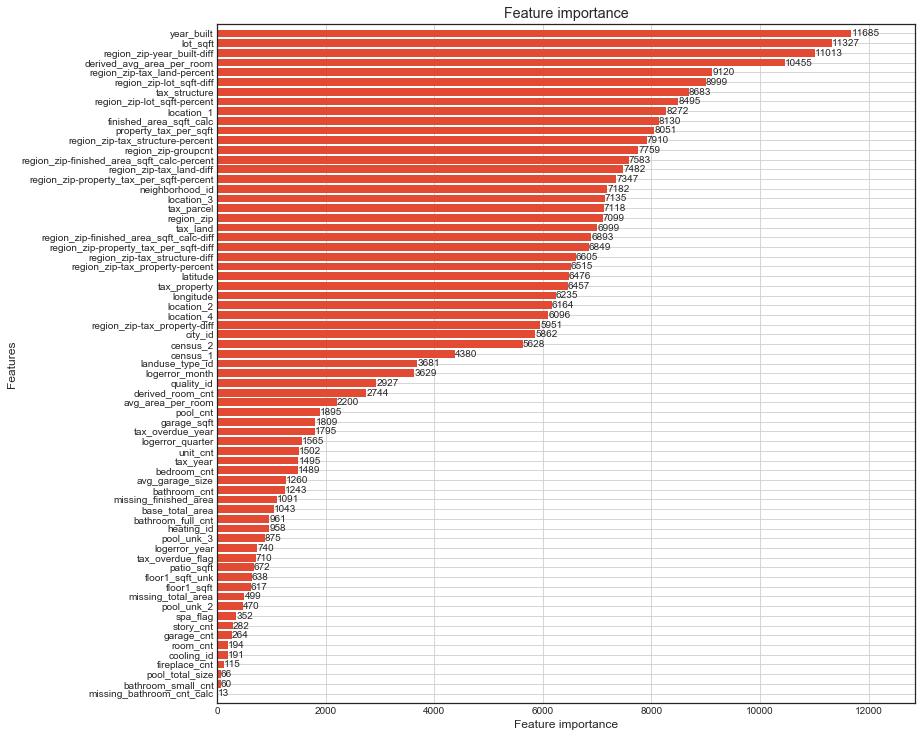

In [35]:
# Plot LightGBM feature importance
lgb.plot_importance(clf, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

In [ ]:
# Helper method for hyperparameter tuning: Sweep a single hyperparameter
def sweep_hyperparam(param_name, sweep):
    feature_names = [s for s in lgb_features.columns]
    categorical_indices = []
    for i, t in enumerate(lgb_features.dtypes):
        if t.name == 'category':
            categorical_indices.append(i)

    lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
    lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

    train_scores = []
    val_scores = []
    for p in sweep:
        print(p)
        np.random.seed(42)
        random.seed(36)
        params[param_name] = p
        clf = lgb.train(params, lgb_train_set, verbose_eval=False,
                    valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                    categorical_feature=categorical_indices)
        train_scores.append(abs(clf.predict(X_train) - y_train).mean() * 100)
        val_scores.append(abs(clf.predict(X_val) - y_val).mean() * 100)

    for i in range(len(sweep)):
        print("{}: train {}, val {}".format(sweep[i], train_scores[i], val_scores[i]))

sweep_hyperparam('learning_rate', [0.0015, 0.003])

# Retrain on all data + Make predictions

In [34]:
# Train LightGBM on all given training data (preparing for submission)
feature_names = [s for s in lgb_features.columns]
categorical_indices = []
for i, t in enumerate(lgb_features.dtypes):
    if t.name == 'category':
        categorical_indices.append(i)
print("Categorical Features:")
print([lgb_features.columns[i] for i in categorical_indices])

del params['early_stopping_rounds']
params['num_boost_round'] = 2000
print(params)

lgb_train_set = lgb.Dataset(lgb_X, label=lgb_y, feature_name=feature_names)
print("lgb_X: {}".format(lgb_X.shape))
print("lgb_y: {}".format(lgb_y.shape))

np.random.seed(42)
random.seed(36)
clf = lgb.train(params, lgb_train_set, verbose_eval=True,
                valid_sets=[lgb_train_set], valid_names=['train'],
                categorical_feature=categorical_indices)

Categorical Features:
['cooling_id', 'heating_id', 'landuse_type_id']

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 13, 21]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



{'objective': 'regression', 'metric': 'mae', 'num_threads': 4, 'boosting_type': 'gbdt', 'num_boost_round': 2000, 'learning_rate': 0.002, 'num_leaves': 150, 'min_data': 90, 'min_hessian': 0.001, 'max_depth': -1, 'max_bin': 255, 'sub_feature': 0.55, 'bagging_fraction': 0.7, 'bagging_freq': 50, 'min_data_per_group': 100, 'cat_smooth': 15.0, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'feature_fraction_seed': 2, 'bagging_seed': 3}
lgb_X: (164299, 69)
lgb_y: (164299,)
[1]	train's l1: 0.0526625
[2]	train's l1: 0.0526589
[3]	train's l1: 0.0526552
[4]	train's l1: 0.0526515
[5]	train's l1: 0.0526479
[6]	train's l1: 0.0526444
[7]	train's l1: 0.0526408
[8]	train's l1: 0.0526372
[9]	train's l1: 0.0526337
[10]	train's l1: 0.0526305
[11]	train's l1: 0.0526268
[12]	train's l1: 0.0526235
[13]	train's l1: 0.0526202
[14]	train's l1: 0.0526166
[15]	train's l1: 0.0526132
[16]	train's l1: 0.0526096
[17]	train's l1: 0.0526062
[18]	train's l1: 0.0526028
[19]	train's l1: 0.0525995
[20]	train's l1: 0.0525961
[21]	tra

[288]	train's l1: 0.0519174
[289]	train's l1: 0.0519155
[290]	train's l1: 0.0519137
[291]	train's l1: 0.0519117
[292]	train's l1: 0.0519097
[293]	train's l1: 0.0519079
[294]	train's l1: 0.0519058
[295]	train's l1: 0.0519039
[296]	train's l1: 0.051902
[297]	train's l1: 0.0519001
[298]	train's l1: 0.0518982
[299]	train's l1: 0.0518962
[300]	train's l1: 0.0518943
[301]	train's l1: 0.0518925
[302]	train's l1: 0.0518905
[303]	train's l1: 0.0518885
[304]	train's l1: 0.0518866
[305]	train's l1: 0.0518847
[306]	train's l1: 0.0518828
[307]	train's l1: 0.051881
[308]	train's l1: 0.0518791
[309]	train's l1: 0.0518772
[310]	train's l1: 0.0518753
[311]	train's l1: 0.0518734
[312]	train's l1: 0.0518716
[313]	train's l1: 0.0518698
[314]	train's l1: 0.0518679
[315]	train's l1: 0.051866
[316]	train's l1: 0.0518642
[317]	train's l1: 0.0518624
[318]	train's l1: 0.0518607
[319]	train's l1: 0.0518589
[320]	train's l1: 0.0518569
[321]	train's l1: 0.051855
[322]	train's l1: 0.0518532
[323]	train's l1: 0.0518

[583]	train's l1: 0.0514568
[584]	train's l1: 0.0514553
[585]	train's l1: 0.0514539
[586]	train's l1: 0.0514526
[587]	train's l1: 0.0514512
[588]	train's l1: 0.0514498
[589]	train's l1: 0.0514484
[590]	train's l1: 0.0514471
[591]	train's l1: 0.0514458
[592]	train's l1: 0.0514445
[593]	train's l1: 0.0514432
[594]	train's l1: 0.0514419
[595]	train's l1: 0.0514408
[596]	train's l1: 0.0514393
[597]	train's l1: 0.0514379
[598]	train's l1: 0.0514366
[599]	train's l1: 0.0514353
[600]	train's l1: 0.0514338
[601]	train's l1: 0.0514324
[602]	train's l1: 0.0514311
[603]	train's l1: 0.0514299
[604]	train's l1: 0.0514286
[605]	train's l1: 0.0514273
[606]	train's l1: 0.051426
[607]	train's l1: 0.0514247
[608]	train's l1: 0.0514233
[609]	train's l1: 0.051422
[610]	train's l1: 0.0514206
[611]	train's l1: 0.0514194
[612]	train's l1: 0.0514181
[613]	train's l1: 0.0514168
[614]	train's l1: 0.0514155
[615]	train's l1: 0.0514142
[616]	train's l1: 0.0514129
[617]	train's l1: 0.0514115
[618]	train's l1: 0.05

[881]	train's l1: 0.0511011
[882]	train's l1: 0.0511
[883]	train's l1: 0.0510989
[884]	train's l1: 0.0510979
[885]	train's l1: 0.0510969
[886]	train's l1: 0.0510957
[887]	train's l1: 0.0510945
[888]	train's l1: 0.0510935
[889]	train's l1: 0.0510924
[890]	train's l1: 0.0510914
[891]	train's l1: 0.0510904
[892]	train's l1: 0.0510894
[893]	train's l1: 0.0510883
[894]	train's l1: 0.0510873
[895]	train's l1: 0.0510861
[896]	train's l1: 0.0510851
[897]	train's l1: 0.051084
[898]	train's l1: 0.051083
[899]	train's l1: 0.0510819
[900]	train's l1: 0.0510809
[901]	train's l1: 0.0510798
[902]	train's l1: 0.0510789
[903]	train's l1: 0.0510779
[904]	train's l1: 0.0510768
[905]	train's l1: 0.0510757
[906]	train's l1: 0.0510747
[907]	train's l1: 0.0510737
[908]	train's l1: 0.0510727
[909]	train's l1: 0.0510716
[910]	train's l1: 0.0510707
[911]	train's l1: 0.0510698
[912]	train's l1: 0.0510687
[913]	train's l1: 0.0510676
[914]	train's l1: 0.0510666
[915]	train's l1: 0.0510657
[916]	train's l1: 0.05106

[1177]	train's l1: 0.0508056
[1178]	train's l1: 0.0508046
[1179]	train's l1: 0.0508036
[1180]	train's l1: 0.0508027
[1181]	train's l1: 0.0508018
[1182]	train's l1: 0.0508008
[1183]	train's l1: 0.0507999
[1184]	train's l1: 0.0507989
[1185]	train's l1: 0.0507979
[1186]	train's l1: 0.0507968
[1187]	train's l1: 0.0507959
[1188]	train's l1: 0.0507949
[1189]	train's l1: 0.0507941
[1190]	train's l1: 0.050793
[1191]	train's l1: 0.0507921
[1192]	train's l1: 0.050791
[1193]	train's l1: 0.0507901
[1194]	train's l1: 0.0507891
[1195]	train's l1: 0.0507883
[1196]	train's l1: 0.0507874
[1197]	train's l1: 0.0507865
[1198]	train's l1: 0.0507856
[1199]	train's l1: 0.0507845
[1200]	train's l1: 0.0507837
[1201]	train's l1: 0.0507827
[1202]	train's l1: 0.0507817
[1203]	train's l1: 0.0507807
[1204]	train's l1: 0.0507798
[1205]	train's l1: 0.050779
[1206]	train's l1: 0.0507781
[1207]	train's l1: 0.0507773
[1208]	train's l1: 0.0507763
[1209]	train's l1: 0.0507754
[1210]	train's l1: 0.0507744
[1211]	train's l1

[1461]	train's l1: 0.0505494
[1462]	train's l1: 0.0505485
[1463]	train's l1: 0.0505475
[1464]	train's l1: 0.0505466
[1465]	train's l1: 0.0505459
[1466]	train's l1: 0.050545
[1467]	train's l1: 0.0505443
[1468]	train's l1: 0.0505435
[1469]	train's l1: 0.0505428
[1470]	train's l1: 0.050542
[1471]	train's l1: 0.050541
[1472]	train's l1: 0.0505401
[1473]	train's l1: 0.0505393
[1474]	train's l1: 0.0505384
[1475]	train's l1: 0.0505375
[1476]	train's l1: 0.0505368
[1477]	train's l1: 0.0505361
[1478]	train's l1: 0.0505353
[1479]	train's l1: 0.0505343
[1480]	train's l1: 0.0505335
[1481]	train's l1: 0.0505326
[1482]	train's l1: 0.0505317
[1483]	train's l1: 0.0505309
[1484]	train's l1: 0.0505301
[1485]	train's l1: 0.0505292
[1486]	train's l1: 0.0505283
[1487]	train's l1: 0.0505276
[1488]	train's l1: 0.0505268
[1489]	train's l1: 0.0505259
[1490]	train's l1: 0.0505252
[1491]	train's l1: 0.0505244
[1492]	train's l1: 0.0505236
[1493]	train's l1: 0.0505229
[1494]	train's l1: 0.0505221
[1495]	train's l1

[1751]	train's l1: 0.0503059
[1752]	train's l1: 0.0503052
[1753]	train's l1: 0.0503045
[1754]	train's l1: 0.0503036
[1755]	train's l1: 0.0503028
[1756]	train's l1: 0.0503021
[1757]	train's l1: 0.0503014
[1758]	train's l1: 0.0503006
[1759]	train's l1: 0.0502998
[1760]	train's l1: 0.0502991
[1761]	train's l1: 0.0502982
[1762]	train's l1: 0.0502974
[1763]	train's l1: 0.0502968
[1764]	train's l1: 0.050296
[1765]	train's l1: 0.0502952
[1766]	train's l1: 0.0502944
[1767]	train's l1: 0.0502935
[1768]	train's l1: 0.0502927
[1769]	train's l1: 0.0502919
[1770]	train's l1: 0.0502911
[1771]	train's l1: 0.0502902
[1772]	train's l1: 0.0502894
[1773]	train's l1: 0.0502886
[1774]	train's l1: 0.0502879
[1775]	train's l1: 0.0502872
[1776]	train's l1: 0.0502865
[1777]	train's l1: 0.0502857
[1778]	train's l1: 0.050285
[1779]	train's l1: 0.0502842
[1780]	train's l1: 0.0502835
[1781]	train's l1: 0.0502827
[1782]	train's l1: 0.050282
[1783]	train's l1: 0.0502813
[1784]	train's l1: 0.0502805
[1785]	train's l1

In [36]:
%%time
def predict_and_export(clf, prop_2016, prop_2017, file_name):
    # Construct DataFrame for prediction results
    submission_2016 = pd.DataFrame()
    submission_2017 = pd.DataFrame()
    submission_2016['ParcelId'] = prop_2016.parcelid
    submission_2017['ParcelId'] = prop_2017.parcelid
    
    # Construct features and make prediction
    test_features_2016 = data_proc.drop_features(prop_2016)
    test_features_2017 = data_proc.drop_features(prop_2017)
    
#     test_dates = ['2016-10-01', '2016-11-01', '2016-12-01',
#                   '2017-10-01', '2017-11-01', '2017-12-01']
#     test_columns = ['201610', '201611', '201612',
#                     '201710', '201711', '201712']

    # Month and quarter features don't help performance much, but increases inference time by 3x
    # Consider not using them when producing submission file
    test_dates = ['2016-10-01', '2017-10-01']
    test_columns = ['201610', '201710']
    
    for d, c in zip(test_dates, test_columns):
        print("Start predicting for {}".format(c))
        
        if d[:4] == '2016':
            test_features = test_features_2016
        else:
            test_features = test_features_2017
        
        test_features['transactiondate'] = d
        test_features = data_proc.add_datetime_aggregate_features(test_features,
                                                                  logerror_year, logerror_month, logerror_quarter)
        pred_test = clf.predict(test_features)
        pred_test = [float(format(x, '.4f')) for x in pred_test]
        
        if d[:4] == '2016':
            submission_2016[c] = pred_test
        else:
            submission_2017[c] = pred_test
        
        print("Finished predicting for {}".format(c))
    
    submission_2016['201611'] = submission_2016['201610']
    submission_2016['201612'] = submission_2016['201610']
    submission_2017['201711'] = submission_2017['201710']
    submission_2017['201712'] = submission_2017['201710']
    
    submission = submission_2016.merge(how='inner', right=submission_2017, on='ParcelId')
    
    print("Length of submission DataFrame: {}".format(len(submission)))
    print("Submission header:")
    print(submission.head())
    submission.to_csv(file_name, index=False)
    return submission  # Return the results just in case we want to analyze or sanity check it

submission = predict_and_export(clf, prop_2016, prop_2017, 'data/submission_180103_v2.csv')

Start predicting for 201610
Finished predicting for 201610
Start predicting for 201710
Finished predicting for 201710
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147  0.0097  0.0097  0.0097  0.0155  0.0155  0.0155
1  10759547  0.0063  0.0063  0.0063  0.0082  0.0082  0.0082
2  10843547  0.0289  0.0289  0.0289  0.0440  0.0440  0.0440
3  10859147  0.0336  0.0336  0.0336  0.0314  0.0314  0.0314
4  10879947 -0.0034 -0.0034 -0.0034 -0.0037 -0.0037 -0.0037
CPU times: user 1h 1min 5s, sys: 28.6 s, total: 1h 1min 34s
Wall time: 16min 13s


In [37]:
submission.head(10)

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.0097,0.0097,0.0097,0.0155,0.0155,0.0155
1,10759547,0.0063,0.0063,0.0063,0.0082,0.0082,0.0082
2,10843547,0.0289,0.0289,0.0289,0.0440,0.0440,0.0440
3,10859147,0.0336,0.0336,0.0336,0.0314,0.0314,0.0314
4,10879947,-0.0034,-0.0034,-0.0034,-0.0037,-0.0037,-0.0037
5,10898347,0.0272,0.0272,0.0272,0.0255,0.0255,0.0255
6,10933547,0.0041,0.0041,0.0041,0.0067,0.0067,0.0067
7,10940747,0.0540,0.0540,0.0540,0.0433,0.0433,0.0433
8,10954547,0.0050,0.0050,0.0050,0.0097,0.0097,0.0097
9,10976347,0.0237,0.0237,0.0237,0.0211,0.0211,0.0211
